# Predicting Game Newsletter Subscription Using Player Characteristics and Behavior 

## Introduction: 
In many industries, it is crucial to understand their target audience and their behaviours as a means to alter and create a product or service that is beneficial to many. More specifically, game publishers and developers must have a thorough understanding of player behaviour. Not only does it enable businesses to market and advertise their product and/or services effectively, but it also can enhance player engagement and even customize experiences. Outside of games, a newsletter that requires a subscription is one of the many ways game publishers and developers can interact with users beyond the game itself. This project will explore which in-game behaviours and players' attributes predict a player's decision to sign up for a newsletter. 


## Question

To investigate and explore which in-game behaviours and player attributes can predict a player's decision to subscribe to a newsletter, this project will aim to answer the question: 
Can a player's total playtime, session frequency and age predict whether they will subscribe to a game-related newsletter? 


## Data Description 


To answer the predictive question above, this project utilizes, extracts and modifies data from two different datasets: players.csv and sessions.csv 

### players.csv
players.csv mainly contains information degarding player demographics and subscription status containing the following variables 

### sessions.csv
sessions.csv primarily logs and keeps record of game play sessions. In other words contains time-stamped session activity 




### Variables from players.csv

| Variable       | Type     | Description                                 |
|----------------|----------|---------------------------------------------|
| hashedEmail    | chr      | Anonymized player ID                        |
| subscribe      | lgl/fct  | TRUE/FALSE or 1/0 for subscription status   |
| age            | dbl      | Player age                                  |
| played_hours   | dbl      | Deprecated metric, not used in model        |
| experience     | chr      | Player experience level (e.g., Pro, Amateur)|
| gender         | chr      | Player gender                               |


### Variables from sessions.csv


| Variable        | Type  | Description                                           |
|-----------------|-------|-------------------------------------------------------|
| hashedEmail     | chr   | Anonymized player ID used for joining datasets        |
| start_time      | chr   | Session start timestamp                               |
| end_time        | chr   | Session end timestamp                                 |
| session_length  | dbl   | Computed length of session in minutes                 |


### Computed Variables 

| Variable        | Type    | Description                                    |
|-----------------|---------|------------------------------------------------|
| total_playtime  | dbl     | Sum of all session lengths for a player        |
| session_count   | int     | Number of valid sessions per player            |
| age_group       | factor  | Categorized age ranges (0–9, 10–19, etc.)      |



### Variables Used in Analysis 

| Variable        | Type    | Description                                      |
|-----------------|---------|--------------------------------------------------|
| subscribe       | factor  | Target variable: whether player subscribed       |
| age             | dbl     | Player age                                       |
| total_playtime  | dbl     | Total playtime in minutes                        |
| session_count   | int     | Number of gameplay sessions                      |
| age_group       | factor  | Age bucket used for grouping and plots           |





# Methods and Results 

As the very first step, it was required to load various libraries in the notebook for a plethora of reasons. Firsly, a majority of the functions used on a daily basis in R like ggplot(), read_csv(), filter(), etc, are not actually built into base R. They are known to come from external packages like the ones listed below, so loading it using the function library(package_name) before using any of its functions. I have done so below of some common packages that will be required for hte analysis to follow.  

In [1]:
library(tidyverse)
library(lubridate)
library(tidymodels)
library(janitor)
library(tibble)
library(knitr)

options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Before any analysis or data wranglign takes place, I first located the raw data files stored in a GitHub repository. To ensure analysis is portable adn reproducavle, the datasets were uplladed to GitHub and provided access to their raw file URLs, making it possible for anyone with the notebook to rerun the analysis from scratch without requiring local files. 

In [2]:
players <- read_csv("https://raw.githubusercontent.com/Zohranikjo/Files-/refs/heads/main/players.csv")
players 
sessions <- read_csv("https://raw.githubusercontent.com/Zohranikjo/Files-/refs/heads/main/sessions.csv") 
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


After imported, I wrangled the sessions.csv dataset. Since the timestamps were originally stored as strings, we used ymd_hms() to transform them into appropriate datetime objects. Each sessions duration was first determined in seconds and then changed to minutes, which is a more comprehensible unit for the length of gameplay. Also, sessions with negative or zero durations were filtered out and removed. 

In [3]:
# 1. Calculate session length safely
sessions <- sessions |> 
  mutate(
    start_time = ymd_hms(start_time),
    end_time = ymd_hms(end_time),
    session_seconds = as.numeric(difftime(end_time, start_time, units = "secs")),
    session_length = session_seconds / 60  # minutes
  ) |>
  filter(session_length > 0) |>  # ❗ remove negative/zero durations
  select(-session_seconds) |> 
  relocate(session_length, .after = end_time)
 
sessions 

hashedEmail,start_time,end_time,session_length,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2030-06-21 00:18:12,2030-06-21 00:18:24,0.2000000,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2017-06-21 00:23:33,2017-06-21 00:23:46,0.2166667,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2025-07-21 00:17:34,2025-07-21 00:17:57,0.3833333,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2028-07-21 00:15:36,2028-07-21 00:15:57,0.3500000,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2025-07-21 00:06:15,2025-07-21 00:06:22,0.1166667,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2020-05-21 00:02:26,2020-05-21 00:02:45,0.3166667,1.71617e+12,1.71617e+12


After that, I calculated the total playtime and number of sessions and grouped the session data by email to summarize it at the player level:

In [4]:
# 2. Summarize playtime + sessions per player
session_summary <- sessions |> 
  group_by(hashedEmail) |> 
  summarize(
    total_playtime = sum(session_length, na.rm = TRUE),
    session_count = n()
  )
session_summary 

hashedEmail,total_playtime,session_count
<chr>,<dbl>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,5.255778e+05,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,5.000000e-01,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1.833333e-01,1
⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2105263.92,310
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,0.15,1
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,1.20,1


Such session data was then joined with players.csv to give a combined dataset

In [5]:
# 3. Join with players dataset
player_data <- players |>
  left_join(session_summary, by = "hashedEmail")
player_data

experience,subscribe,hashedEmail,played_hours,name,gender,Age,total_playtime,session_count
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2.102335e+06,26
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,4.250000e+00,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,8.333333e-02,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,0.08333333,1
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,2.98333333,6
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,0.25000000,1


Following the merge, the relevent columns were cleaned and selected, to remove players with no playtime and dealing with any missing values. 

In [6]:
# 4. Prepare modeling data
model_data <- player_data |> 
  select(subscribe, Age, total_playtime, session_count) |> 
  drop_na() |>   
  filter(total_playtime > 0)
model_data 

subscribe,Age,total_playtime,session_count
<lgl>,<dbl>,<dbl>,<int>
TRUE,9,2.102335e+06,26
TRUE,17,4.250000e+00,3
FALSE,17,8.333333e-02,1
⋮,⋮,⋮,⋮
FALSE,22,0.35000000,1
FALSE,17,0.08333333,1
FALSE,17,2.98333333,6


In order to aid group analysis and better interpretability, two new columns were created, which converted playtime into mins for better interpretation, and bucketed age into various age groups for easier comparison. 





In [7]:
model_data <- model_data |> 
  mutate(age_group = cut(
    Age,
    breaks = c(0, 9, 19, 29, 39, 49, 59, Inf),
    labels = c("0–9", "10–19", "20–29", "30–39", "40–49", "50–59", "60+"),
    right = TRUE, include.lowest = TRUE
  ))
model_data

subscribe,Age,total_playtime,session_count,age_group
<lgl>,<dbl>,<dbl>,<int>,<fct>
TRUE,9,2.102335e+06,26,0–9
TRUE,17,4.250000e+00,3,10–19
FALSE,17,8.333333e-02,1,10–19
⋮,⋮,⋮,⋮,⋮
FALSE,22,0.35000000,1,20–29
FALSE,17,0.08333333,1,10–19
FALSE,17,2.98333333,6,10–19


To continue on the analysis based on age group, I computed the average playtime per age group and subscription status, making sure that all combinations appear even if the count is 0. 

In [8]:
playtime_summary <- model_data |>
  mutate(age_group = factor(age_group, levels = c("0–9", "10–19", "20–29", "30–39", "40–49", "50–59", "60+"))) |> 
  group_by(age_group, subscribe, .drop = FALSE) |>
  summarize(
    mean_playtime = mean(total_playtime, na.rm = TRUE),
    .groups = "drop"
  )
playtime_summary

playtime_summary <- playtime_summary |>
  replace_na(list(mean_playtime = 0))

playtime_summary

age_group,subscribe,mean_playtime
<fct>,<lgl>,<dbl>
0–9,TRUE,1051167.8
10–19,FALSE,30917.3
10–19,TRUE,604145.6
⋮,⋮,⋮
40–49,TRUE,5.255864e+05
50–59,FALSE,8.333333e-02
60+,NA,NaN


age_group,subscribe,mean_playtime
<fct>,<lgl>,<dbl>
0–9,TRUE,1051167.8
10–19,FALSE,30917.3
10–19,TRUE,604145.6
⋮,⋮,⋮
40–49,TRUE,5.255864e+05
50–59,FALSE,8.333333e-02
60+,NA,0.000000e+00


Three different exploratory vizualizations were created. plot_subscription_count_by_age_group is a bar chart comparing how many players in each age group subscribed vs did not. plot_grouped_bar_playtime on the other hand sumarized the relationship between playtime and subscription within age bins. Lastly, plot_age_distribution allows us to determine whether subscribers vs non-subscribers differ in age. 

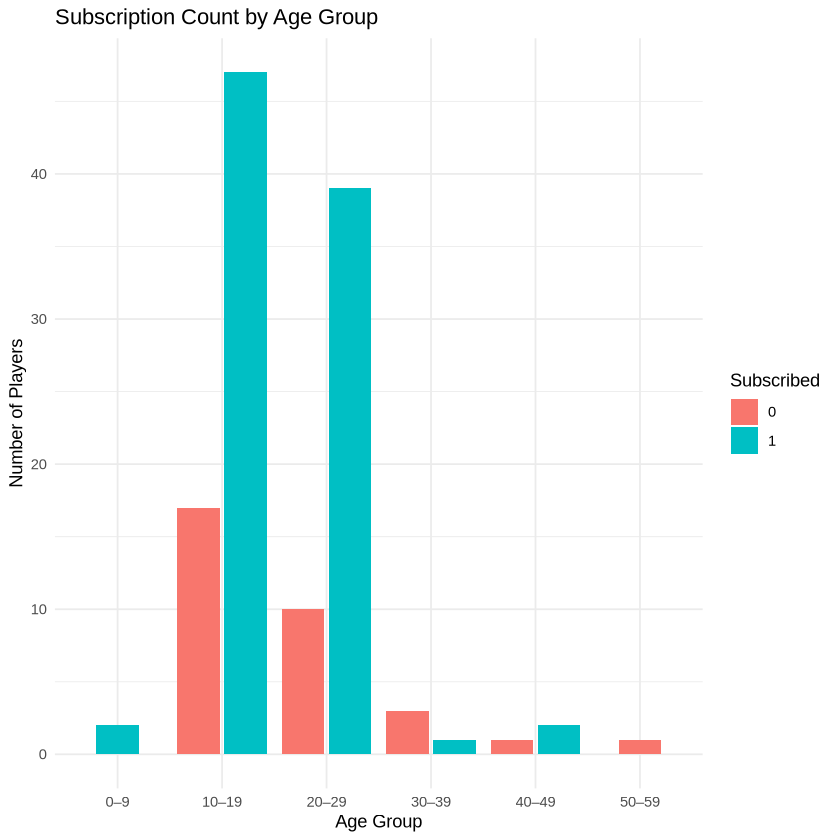

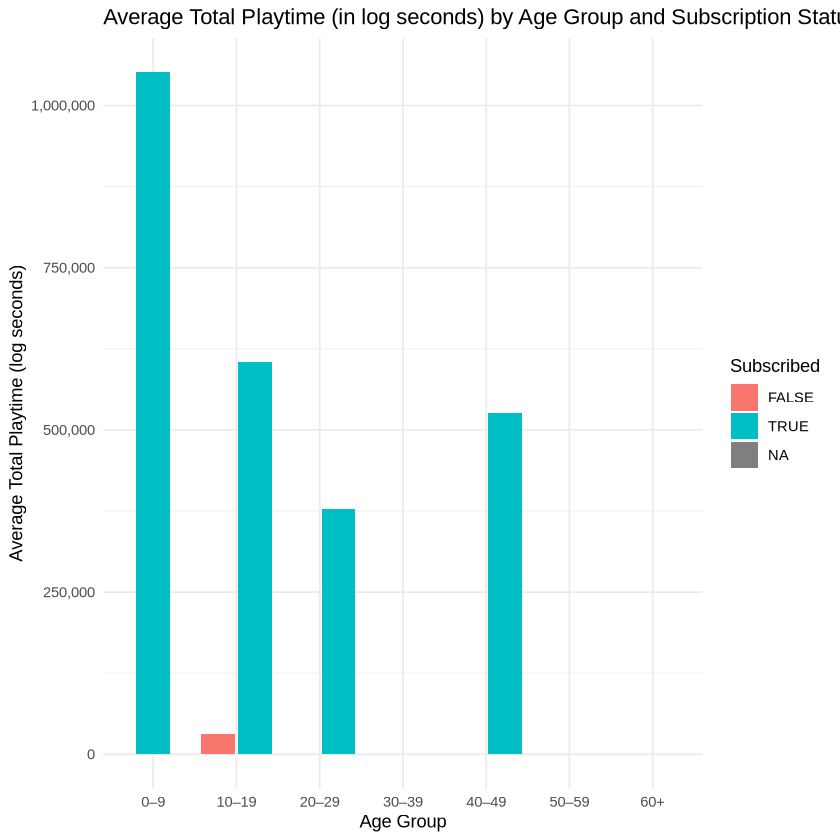

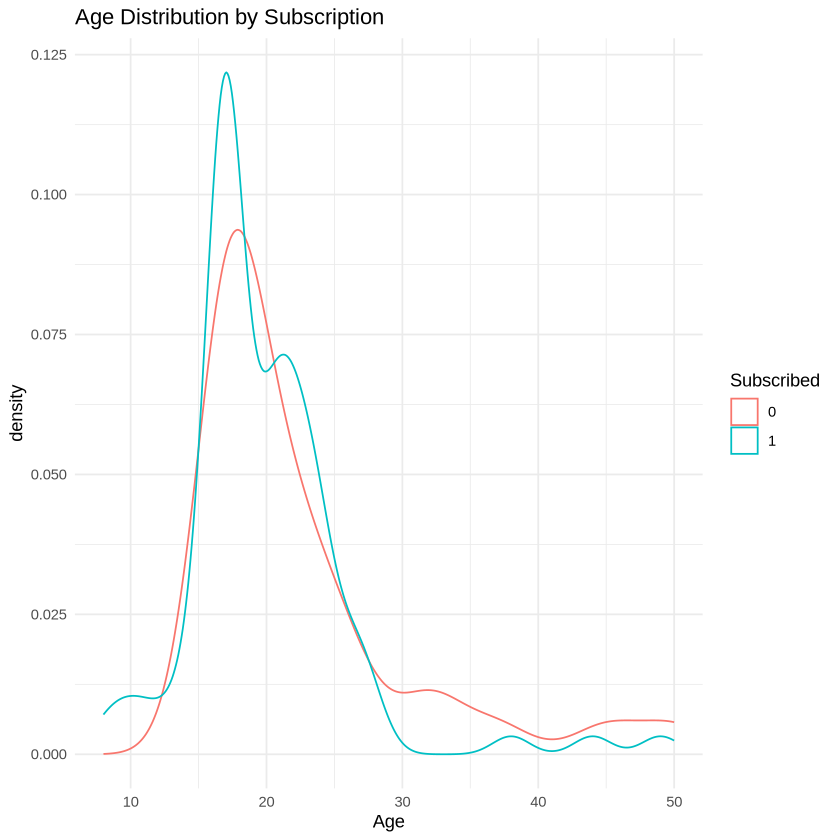

In [29]:
# 1. Subscription count bar plot (grouped by age group)
plot_subscription_count_by_age_group <- ggplot(model_data, aes(x = age_group, fill = subscribe)) +
  geom_bar(position = position_dodge2(preserve = "single")) +
  labs(
    title = "Subscription Count by Age Group",
    x = "Age Group",
    y = "Number of Players",
    fill = "Subscribed"
  ) +
  theme_minimal()

plot_subscription_count_by_age_group

# 2. Average total playtime (minutes) by age group and subscription status
plot_grouped_bar_playtime <- ggplot(playtime_summary, aes(x = age_group, y = mean_playtime, fill = subscribe)) +
  geom_bar(stat = "identity", position = position_dodge2(preserve = "single")) +
  scale_y_continuous(labels = scales::comma_format(accuracy = 1)) +
  #scale_y_continuous(trans='log10') +
  
  labs(
    title = "Average Total Playtime (in log seconds) by Age Group and Subscription Status",
    x = "Age Group",
    y = "Average Total Playtime (log seconds)",
    fill = "Subscribed"
  ) +
  theme_minimal()


plot_grouped_bar_playtime

# 3. Age distribution density plot (uses Age column + labeled object)
plot_age_distribution <- ggplot(model_data, aes(x = Age, color = factor(subscribe))) +
  geom_density() +
  labs(
    title = "Age Distribution by Subscription",
    x = "Age",
    color = "Subscribed"
  ) +
  theme_minimal()

plot_age_distribution


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


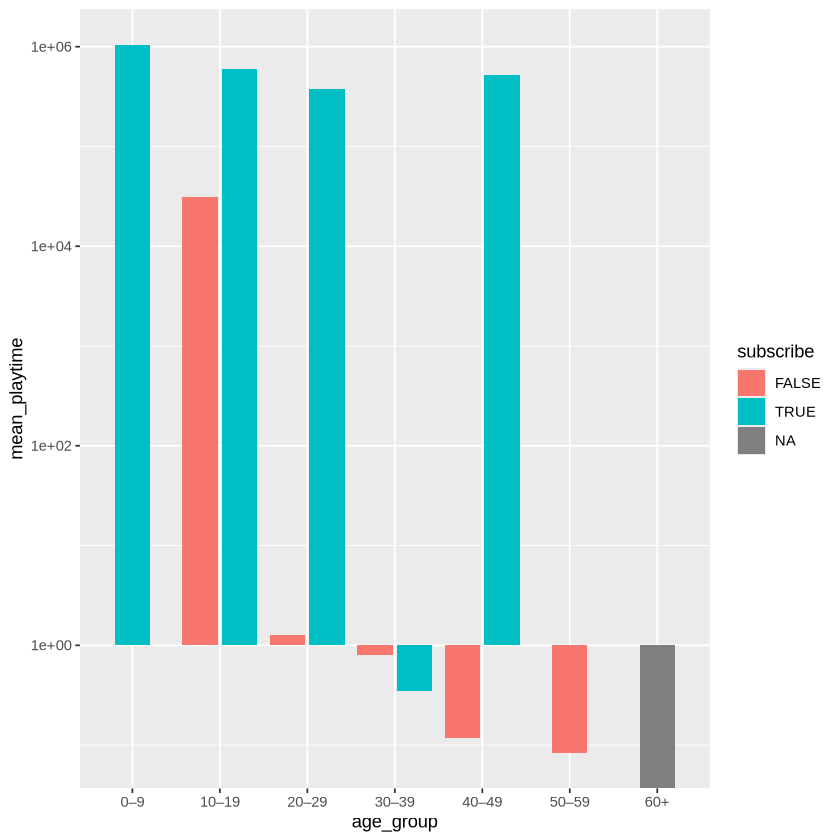

In [11]:
ggplot(playtime_summary, aes(x = age_group, y = mean_playtime, fill = subscribe)) +
  geom_bar(stat = "identity", position = position_dodge2(preserve = "single")) +
  #scale_y_continuous(labels = scales::comma_format(accuracy = 1)) +
  #scale_y_continuous(trans='log10')
  scale_y_log10()


The begin the classification analysis, the code below prepares the subscribe column for classification by converting its logical labels to character labels ("1"/"0"). To make sure the model only uses clean, legitimate data, it also eliminates rows with missing values.

In [12]:
model_data <- model_data |> 
  mutate(subscribe = case_when(
    subscribe == TRUE ~ "1",
    subscribe == FALSE ~ "0",
    TRUE ~ NA_character_
  )) |> 
  filter(!is.na(subscribe))

model_data

subscribe,Age,total_playtime,session_count,age_group
<chr>,<dbl>,<dbl>,<int>,<fct>
1,9,2.102335e+06,26,0–9
1,17,4.250000e+00,3,10–19
0,17,8.333333e-02,1,10–19
⋮,⋮,⋮,⋮,⋮
0,22,0.35000000,1,20–29
0,17,0.08333333,1,10–19
0,17,2.98333333,6,10–19


Subscribe is a binary response variable. To determine whether new players are likely to become subscribers or not, classification is necessary. KNN makes these predictions by utilizing the idea of "closeness" in feature space. 

Firstly, a random seed is set so that the results are reproducible, ensuring that everyone running the same code will obtain the same data split. 

Below, the model_data is split into training and testing sets, while strata = subscribe, ensures class balance so that we have a similar proportion of TRUE/FALSE in both sets. 

In [13]:

set.seed(123)
split <- initial_split(model_data, strata = subscribe)
train <- training(split)
test <- testing(split)



Using Age, total_playtime, and session_count as predictors and subscribe as the outcome, the recipe(...) outlines preprocessing for a KNN model. These predictors are normalized by centering and scaling them using step_center() and step_scale(). For KNN, which depends on distance, this is essential because, in the absence of normalization, variables with a larger scale, like total_playtime, would overwhelm those with a smaller scale, like Age.

In [14]:
knn_recipe <- recipe(subscribe ~ Age + total_playtime + session_count, data = train) |> 
  step_center(all_predictors()) |> step_scale(all_predictors()) 
knn_recipe





── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Centering for: all_predictors()

• Scaling for: all_predictors()



The KNN model setup for classification is defined in this cell, with k (number of neighbours) remaining a tunable parameter to determine the ideal value at a later time. It supports neat workflows with preprocessing steps by using equal weighting for all neighbours ("rectangular") and setting the modelling engine to "kknn."

In [15]:
knn_spec <- nearest_neighbor(
  mode = "classification",
  neighbors = tune(),         # we'll tune 'k'
  weight_func = "rectangular" # default: equal weighting
) |> 
  set_engine("kknn")
knn_spec


K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In this step, the preprocessing recipe and the KNN model definition are combined to create a modelling workflow. Reliable tuning and evaluation depend on the consistent application of all transformations and modelling operations, which is ensured by using a workflow.


In [16]:
knn_wf <- workflow() |> 
  add_recipe(knn_recipe) |> 
  add_model(knn_spec)
knn_wf 



══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In this step, the ideal number of neighbours (k) for the KNN model is determined by hyperparameter tuning using 5-fold cross-validation. Accuracy and ROC AUC are used to assess model performance over a range of odd k values (from 1 to 25). This procedure guarantees that the chosen k generalizes well and prevents overfitting to a single train/test split by testing the model on several resampled splits of the training data.

In [17]:
set.seed(999)
folds <- vfold_cv(train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(1, 25, by = 2))  # try k = 1, 3, ..., 25

knn_results <- tune_grid(
  knn_wf,
  resamples = folds,
  grid = k_vals,
  metrics = metric_set(accuracy, roc_auc)
)



To aid in understanding how the model's accuracy varies with varying values of k, this step generates a visualization. We can quickly determine which k provides the best performance and whether accuracy stabilizes or decreases at higher values by charting cross-validation accuracy against the number of neighbours. A more knowledgeable and rational choice of the ideal k is supported by this visual confirmation.

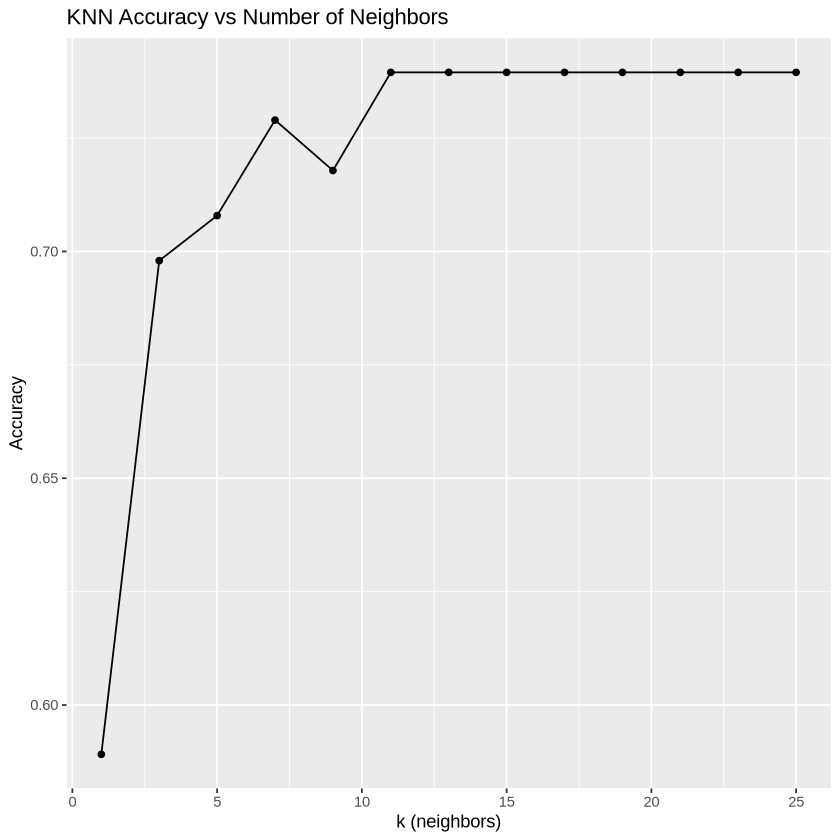

In [18]:
knn_plot <- knn_results |> 
  collect_metrics() |> 
  filter(.metric == "accuracy") |> 
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() + geom_point() +
  labs(title = "KNN Accuracy vs Number of Neighbors", x = "k (neighbors)", y = "Accuracy")

knn_plot


In this step, the model is finalized by retraining it with the optimal number of neighbours (k), which is determined by the highest cross-validation accuracy. Then, using last_fit(), the final KNN model is assessed on the test set (data that was not used for training or tuning), yielding an objective assessment of performance in the real world. This provides the final performance metrics required for reporting and validates how well the optimized model generalizes to unseen data.

In [19]:
best_k <- knn_results |> 
  select_best("accuracy")

final_knn_spec <- nearest_neighbor(
  mode = "classification",
  neighbors = best_k$neighbors,
  weight_func = "rectangular"
) |> 
  set_engine("kknn")

final_wf <- workflow() |> 
  add_recipe(knn_recipe) |> 
  add_model(final_knn_spec)

final_fit <- final_wf |> last_fit(split)

final_fit |> collect_metrics()



.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.7419355,Preprocessor1_Model1
roc_auc,binary,0.6222826,Preprocessor1_Model1


This plot, which displays the number of predictions for each class grouped by the true label, aids in assessing how well the model's predicted classes match the actual subscription status. It graphically illustrates the proportion of accurate versus inaccurate predictions as well as any class bias in the model. This is particularly helpful for identifying systematic misclassifications or class imbalance problems in the finished model.

In [20]:
final_fit |> 
  collect_predictions()

id,.pred_0,.pred_1,.row,.pred_class,subscribe,.config
<chr>,<dbl>,<dbl>,<int>,<fct>,<fct>,<chr>
train/test split,0.09090909,0.9090909,1,1,1,Preprocessor1_Model1
train/test split,0.27272727,0.7272727,2,1,1,Preprocessor1_Model1
train/test split,0.09090909,0.9090909,6,1,0,Preprocessor1_Model1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
train/test split,0.4545455,0.5454545,109,1,0,Preprocessor1_Model1
train/test split,0.1818182,0.8181818,110,1,1,Preprocessor1_Model1
train/test split,0.1818182,0.8181818,111,1,0,Preprocessor1_Model1


In [21]:
final_fit |> 
  collect_predictions() |>
  dplyr::count(.pred_class)

.pred_class,n
<fct>,<int>
1,31


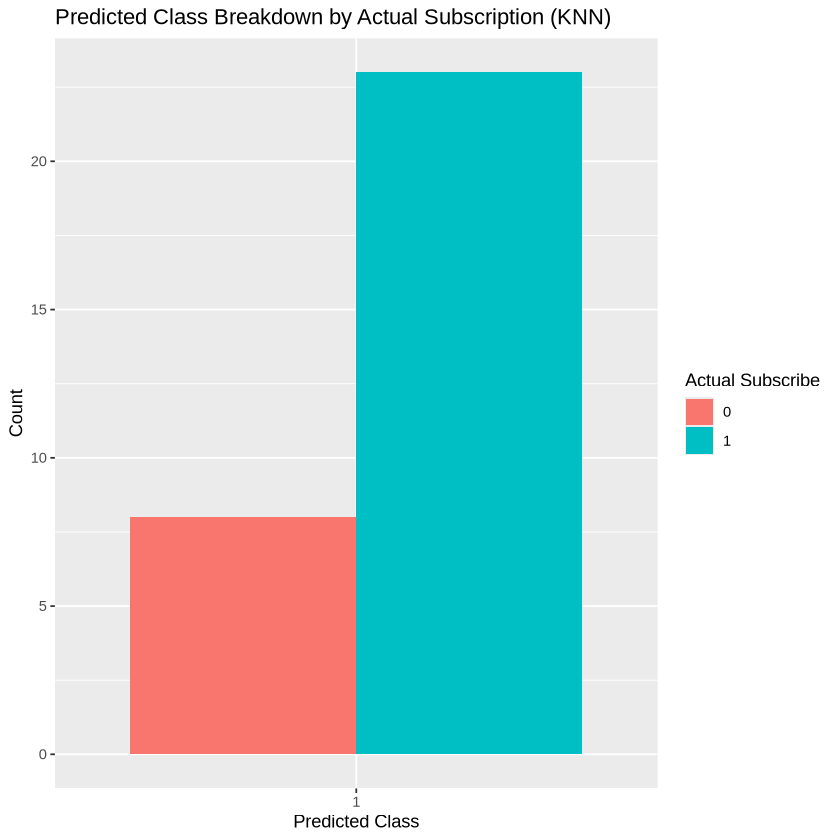

In [22]:
final_fit |> 
  collect_predictions() |> 
  ggplot(aes(x = .pred_class, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Predicted Class Breakdown by Actual Subscription (KNN)",
    x = "Predicted Class", 
    y = "Count", 
    fill = "Actual Subscribe"
  )


Deeper understanding of the model's performance is offered by these two outputs. In order to determine where the model is making mistakes, the confusion matrix provides a thorough breakdown of true positives, false positives, true negatives, and false negatives. By displaying the expected probabilities for the positive class (subscribe = 1), the probability distribution plot illustrates the model's level of prediction confidence. Strong class discrimination is indicated by well-separated distributions, whereas overlapping curves imply that the model has trouble distinguishing between classes.

          Truth
Prediction  0  1
         0  0  0
         1  8 23

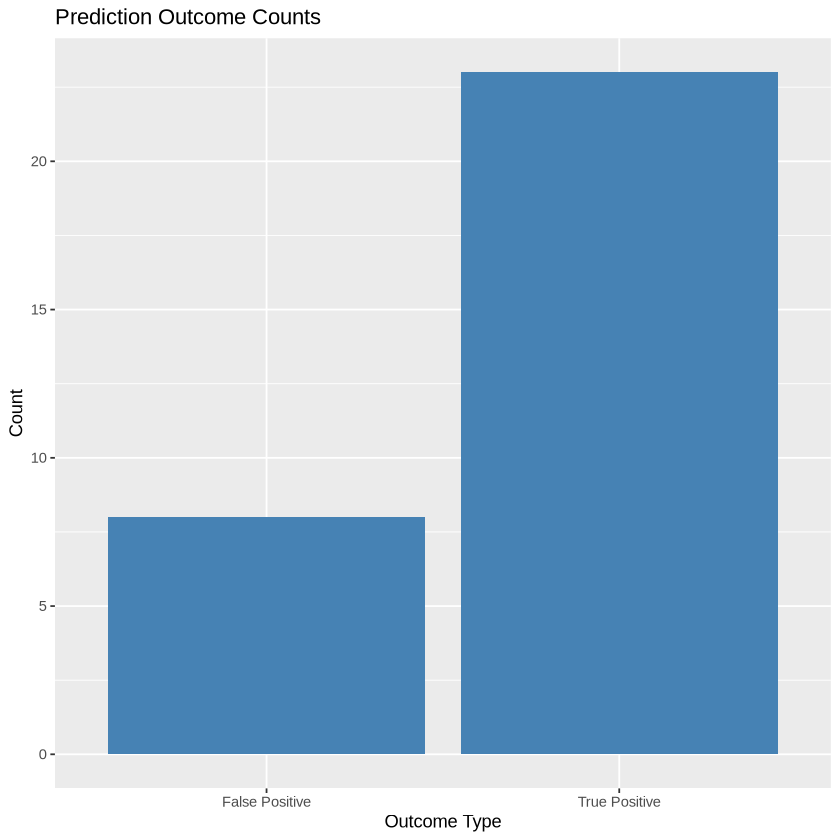

In [23]:
# Confusion matrix
final_fit |> collect_predictions() |> 
  conf_mat(truth = subscribe, estimate = .pred_class)

# Probability distribution

prediction_data <- final_fit |> collect_predictions() |> 
  mutate(result_type = case_when(
    .pred_class == "1" & subscribe == 1 ~ "True Positive",
    .pred_class == "1" & subscribe == 0 ~ "False Positive",
    .pred_class == "0" & subscribe == 1 ~ "False Negative",
    .pred_class == "0" & subscribe == 0 ~ "True Negative"))

ggplot(prediction_data, aes(x = result_type)) +
  geom_bar(fill = "steelblue") +
  labs(title = "Prediction Outcome Counts", x = "Outcome Type", y = "Count")



# Results
Using a classification approach, this project investigated whether a player's age, total playtime, and session frequency could predict whether they would sign up for a game-related newsletter. Because the objective was to categorize players into two groups—subscribed or not—based on numerical and categorical attributes, a K-Nearest Neighbours (KNN) model was selected. We employed 5-fold cross-validation, which divides the training data into multiple folds to assess performance more robustly and ensure the model was dependable and not overfitting. This improved the model's generalizability by enabling us to determine the ideal value for k (number of neighbours).


According to the first bar plot, "Subscription Count by Age Group," most subscribers are between 10 and 29, with very few older players signing up. This demonstrates how age is a reliable indicator. In the second bar plot, "Average Total Playtime (in Minutes) by Age Group and Subscription Status," subscribers have higher total playtimes in nearly every age group, except the 0–9 age group, where playtime surpasses 1,000,000 minutes. This suggests that overall playtime is also a powerful predictor of subscription behaviour.

The third visualization, "Age Distribution by Subscription," is a density plot demonstrating that non-subscribers are more dispersed or skew older. At the same time, subscribers are generally younger, peaking between 17 and 19. These three stories collectively lend credence to the notion that playtime and age are significant predictors.

The optimal k value was then ascertained using the KNN Accuracy vs. Number of Neighbours plot. As k increased, accuracy improved and plateaued at k = 11, which was determined to be the ideal value. According to the corresponding metrics table, the best model obtained an ROC AUC of 0.62 and an accuracy of 74.2%, indicating moderate discriminative power.


The model correctly predicted the majority of subscribers (class "1"). Still, it was unable to identify any players as non-subscribers (class "0"), as shown by the "Predicted Class Breakdown by Actual Subscription (KNN)" bar chart. A bias in the training data or the fact that non-subscribers exhibit less recognizable patterns causes this limitation. Last but not least, the "Predicted Subscription Probabilities (KNN)" histogram demonstrated that the subscriber class accounted for the majority of high-confidence predictions, thereby confirming the model's bias in favour of that result.

All things considered, classification worked well for simulating the connection between player behaviour and subscription status. Cross-validation increased our confidence in the findings by evaluating the model's accuracy across various data subsets. We conclude from this analysis that age and total playtime are reliable indicators of subscription, while session frequency appears to contribute less significantly.



# Discussion 
This study discovered that while session frequency had less impact on newsletter subscription, age and total playtime were powerful predictors. In general, subscribers had significantly more playtime overall, and younger players (ages 10–29) subscribed at higher rates. Cross-validation helped guarantee dependable results, and the KNN model's accuracy was approximately 74%.

These results mostly matched expectations, as higher engagement was assumed to lead to subscriptions. However, the strong role of age—and the weaker role of session count—was somewhat unexpected, suggesting that how long players play matters more than how often they play.

These insights could help developers target subscription prompts more effectively, focusing on younger and highly active users. This could improve marketing efficiency and user retention.

Future questions include whether adding variables like in-game behaviour or purchase history would improve predictions and how subscription trends change with different newsletter formats or timing.   



data set not balanced response variable is inbalanced!